## XGBoost Regressor
> screening and walk-forward optimisation for per minute data of the NIFTY 500

In [1]:
!pip install -q tqdm backtesting joblib

the TVDataFeed API

In [2]:
!pip install -q --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git

  Preparing metadata (setup.py) ... done


In [3]:
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
from tvDatafeed import TvDatafeed, Interval
from backtesting import Backtest
import warnings
from xgboost import XGBRegressor

/usr/local/lib/python3.12/dist-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [4]:
warnings.filterwarnings("ignore")

### Screening

In [5]:
nifty_500 = pd.read_csv("/content/500List.csv").Symbol.to_list()

The Screening Function
> the idea is to find the companies suitable for a regression based predictive model (XGBRegressor)

In [6]:
tv = TvDatafeed()

#### Deriving the globals

In [7]:
import pandas as pd
import numpy as np
import os

def fetch_daily(symbol):
    """
    fetches per day OHLCV data for a
    NSE symbol via TradingView and returns a dataframe
    """
    try:
      df = tv.get_hist(
          symbol=symbol,
          exchange='NSE',
          interval=Interval.in_daily,
          n_bars=1000
      )
      df = df[:int(0.7*len(df)) + 1]
      df.index = df.index.tz_localize("UTC").tz_convert("Asia/Kolkata")
      df.columns = [c.capitalize() for c in df.columns]

      if "Symbol" in df.columns:
          df.drop(columns=["Symbol"], inplace=True)

      df["ret"] = df["Close"].pct_change()
      return df.dropna()
    except:
      print(f"{symbol} not in TvDataFeed's database for the timeframe")

def compute_metrics(symbols):
      """
      computes: volatility, autocorrelation with 1-lag, median volume
      and stability
      """
      rows = []

      for sym in symbols:
          try:
              df = fetch_daily(sym)
              if len(df) < 700:
                  continue

              ret = df['ret']
              if len(ret) < 100:
                  continue

              vol = ret.std()
              ac1 = ret.autocorr(lag=1)

              # stability: CV of rolling vol
              rv = ret.rolling(200).std()
              stab = (rv.std() / rv.mean()) if rv.mean() > 0 else np.nan

              rows.append({
                  'symbol': sym,
                  'vol': vol,
                  'ac1': ac1,
                  'stab': stab,
              })


          except:
              print(f"couldn't compute metrics for {sym}")
              continue

      return pd.DataFrame(rows).dropna()

def derive_globals(metrics_df):
      """
      derives the percentiles based on which
      screening is done.
      """

      globals_out = {
          'VOL_LOW'  : metrics_df['vol'].quantile(0.40),
          'VOL_HIGH' : metrics_df['vol'].quantile(0.90),
          'STAB_MIN' : metrics_df['stab'].quantile(0.40),
          'AC_MIN'   : metrics_df['ac1'].quantile(0.60),
      }

      return globals_out


metrics_df = compute_metrics(nifty_500)
print("metrics_df:")
print(metrics_df.head())

globals_dict = derive_globals(metrics_df)
print("\nDerived Globals:")
for k, v in globals_dict.items():
    print(f"{k}: {v}")

ERROR:tvDatafeed.main:Connection timed out
ERROR:tvDatafeed.main:no data, please check the exchange and symbol


BAJAJ-AUTO not in TvDataFeed's database for the timeframe
couldn't compute metrics for BAJAJ-AUTO


ERROR:tvDatafeed.main:Connection timed out
ERROR:tvDatafeed.main:no data, please check the exchange and symbol


DUMMYSKFIN not in TvDataFeed's database for the timeframe
couldn't compute metrics for DUMMYSKFIN


ERROR:tvDatafeed.main:Connection timed out
ERROR:tvDatafeed.main:no data, please check the exchange and symbol


NAM-INDIA not in TvDataFeed's database for the timeframe
couldn't compute metrics for NAM-INDIA
metrics_df:
    symbol       vol       ac1      stab
0   360ONE  0.021382  0.033883  0.124928
1  3MINDIA  0.018275 -0.036718  0.119262
2      ABB  0.021096 -0.003184  0.125486
3      ACC  0.019766  0.030034  0.096149
4   AIAENG  0.017881  0.025922  0.103126

Derived Globals:
VOL_LOW: 0.020851031583696635
VOL_HIGH: 0.03146073828075781
STAB_MIN: 0.1278231933817813
AC_MIN: 0.0162186963271431


#### Master Screener

In [8]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf

def acf_strength(r, G):
    ac1 = r.autocorr(lag=1)
    return ac1 >= G["AC_MIN"]

def volatility_pass(std, G):
    return (G['VOL_LOW'] <= std <= G['VOL_HIGH'])

def stability_value(r, window=200):
    if len(r) < window * 2:
        return None
    rv = pd.Series(r).rolling(window).var().dropna()
    if len(rv) == 0:
        return None
    cv = rv.std() / rv.mean()
    return cv

def screen(symbol, df, G):
    try:
      r = df["ret"]
      if len(r) < 200:
          return None

      # volatility filter
      vol = r.std()
      if not volatility_pass(vol, G):
          return None

      # autocorrelation
      if not acf_strength(r, G):
          return None

      # stability
      stab_val = stability_value(r)
      if stab_val is None or stab_val > (1 / G['STAB_MIN']):
          return None

      # combine into score
      score = (
          (vol - G['VOL_LOW']) / (G['VOL_HIGH'] - G['VOL_LOW']) +
          (G['STAB_MIN'] / stab_val)
      )

      return (symbol, score)
    except:
      print("couldn't get the returns column")

In [ ]:
results = []

for sym in tqdm(nifty_500):
    try:
        df = fetch_daily(sym)
        if len(df) < 700: continue
    except Exception as e:
        print(f"Error fetching {sym}: {e}")
        continue

    out = screen(sym, df, globals_dict)
    if out:
        print(f"Selected: {out}")
        results.append(out)

ranked = sorted(results, key=lambda x: x[1], reverse=True)

for sym, score in ranked[:10]:
    print(sym, score)

```
[('SCHNEIDER', np.float64(1.7146693589179844)),
 ('SAMMAANCAP', np.float64(1.6961317145393235)),
 ('IRB', np.float64(1.570547188403514)),
 ('INTELLECT', np.float64(1.5470799856630337)),
 ('LODHA', np.float64(1.524082438602976)),
 ('PGEL', np.float64(1.3994762971559245)),
 ('ZENTEC', np.float64(1.3847449447501279)),
 ('OLECTRA', np.float64(1.372713435058598)),
 ('TEJASNET', np.float64(1.3652006881918395)),
 ('GVT&D', np.float64(1.3646740891554108))]
```



In [59]:
tickers = [x[0] for x in ranked[:20]]
tickers

['SCHNEIDER',
 'SAMMAANCAP',
 'IRB',
 'INTELLECT',
 'LODHA',
 'PGEL',
 'ZENTEC',
 'OLECTRA',
 'TEJASNET',
 'GVT&D',
 'HSCL',
 'SAREGAMA',
 'GODFRYPHLP',
 'SCI',
 'FORCEMOT',
 'BDL',
 'POLICYBZR',
 'BSE',
 'BEML',
 'KEC']

### Evaluation Function

In [60]:
def evaluate_model(y_true, y_pred):
    """
    Compact evaluation suite for next-day return prediction.
    """
    import numpy as np
    from sklearn.metrics import (
        mean_absolute_error,
        mean_squared_error,
        r2_score
    )

    # core errors
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # signal metrics
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    true_dir = np.sign(y_true)
    pred_dir = np.sign(y_pred)
    da = (true_dir == pred_dir).mean()

    # tails
    thr = np.percentile(np.abs(y_true), 90)
    mask = np.abs(y_true) >= thr
    tail = (np.sign(y_true[mask]) == np.sign(y_pred[mask])).mean() if mask.any() else None

    # naive trading value
    strat = pred_dir * y_true
    sharpe = strat.mean() / strat.std() if strat.std() > 0 else None

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Correlation": corr,
        "Directional_Accuracy": da,
        "Tail_Hit_Rate": tail,
        "Naive_Strategy_Sharpe": sharpe
    }

### Training, Testing, and Evaluating Separate Regressor per Ticker

In [18]:
def create_xgbregressor(symbol: str):
    import yfinance as yf
    import numpy as np
    import joblib
    from xgboost import XGBRegressor

    # fetch
    data = tv.get_hist(
          symbol=symbol,
          exchange='NSE',
          interval=Interval.in_daily,
          n_bars=1000
      )
    data.index = data.index.tz_localize('UTC')
    data.index = data.index.tz_convert('Asia/Kolkata')
    data.columns = [col.capitalize() for col in data.columns]

    # target: tomorrow’s percent change
    data['change_tomorrow'] = data['Close'].pct_change().shift(-1)
    data = data.dropna()

    target = 'change_tomorrow'
    y = data[target]
    X = data.drop(columns=[target, 'Symbol'])

    # time-ordered split
    split = int(len(X) * 0.7) + 1
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    model = XGBRegressor(
        min_child_weight=10,
        objective='reg:squarederror'
    )
    model.fit(X_train, y_train)

    # evaluation
    preds = model.predict(X_test)
    metrics = evaluate_model(y_test.values, preds)
    print(f"{symbol}: {metrics}")

    joblib.dump(model, f'/content/xgb/xgboost_model_{symbol.replace(".NS", "")}.joblib')

In [61]:
from tqdm import tqdm

for symbol in tickers:
  try:
    create_xgbregressor(f"{symbol}")
  except:
    continue

SCHNEIDER: {'MAE': 0.027224401165801507, 'MSE': 0.0011467513947927728, 'RMSE': np.float64(0.03386371797060643), 'R2': -0.5890078069850482, 'Correlation': np.float64(0.04495543816723584), 'Directional_Accuracy': np.float64(0.5150501672240803), 'Tail_Hit_Rate': np.float64(0.4666666666666667), 'Naive_Strategy_Sharpe': np.float64(0.03662038835074963)}
SAMMAANCAP: {'MAE': 0.02733719753800366, 'MSE': 0.0012387626006803729, 'RMSE': np.float64(0.03519605944818784), 'R2': -0.33016914514504125, 'Correlation': np.float64(0.052835709958868576), 'Directional_Accuracy': np.float64(0.5083612040133779), 'Tail_Hit_Rate': np.float64(0.6666666666666666), 'Naive_Strategy_Sharpe': np.float64(0.011095211123371255)}
IRB: {'MAE': 0.029438448335259187, 'MSE': 0.0014474045849039814, 'RMSE': np.float64(0.038044770795787185), 'R2': -2.155377179856057, 'Correlation': np.float64(0.020921439050741248), 'Directional_Accuracy': np.float64(0.5050167224080268), 'Tail_Hit_Rate': np.float64(0.43333333333333335), 'Naive_St

### Testing Inference

In [93]:
model = joblib.load("/content/xgb/xgboost_model_POLICYBZR.joblib")

In [94]:
data = tv.get_hist(
          symbol='POLICYBZR',
          exchange='NSE',
          interval=Interval.in_daily,
          n_bars=100
      )
data.index = data.index.tz_localize('UTC')
data.drop(columns=['symbol'], inplace=True)
data.index = data.index.tz_convert('Asia/Kolkata')
len(data)

100

In [95]:
data['change tomorrow'] = data['close'].pct_change().shift(-1)
data.dropna(inplace=True)

target = 'change tomorrow'
y = data[target]
x = data.drop(columns=[target])

# Capitalize column names to match the loaded model's expected feature names
x.columns = [col.capitalize() for col in x.columns]

In [96]:
y_pred = model.predict(x)

In [97]:
error = y - y_pred

<Axes: xlabel='datetime'>

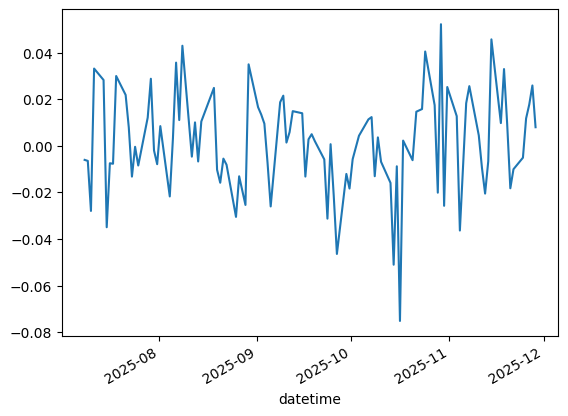

In [98]:
error.plot()

In [99]:
error2 = error ** 2
MSE = error2.mean()
RMSE = MSE ** 0.5

In [100]:
RMSE

np.float64(0.021511320445964648)

### Backtesting

In [101]:
from backtesting import Strategy

class MlStrategy(Strategy):
  def init(self):
    self.model = model

  def next(self):
    x_today = self.data.df.iloc[[-1]]
    y_tomorrow = self.model.predict(x_today)

    if y_tomorrow > RMSE:
      self.buy()
    elif y_tomorrow < -RMSE:
      self.sell()
    else:
      pass

In [102]:
from backtesting import Backtest

bt = Backtest(
    x, MlStrategy, cash=1_00_000, commission=0.0002,
    exclusive_orders=True, trade_on_close=True
)

results = bt.run()
results

Backtest.run:   0%|          | 0/98 [00:00<?, ?bar/s]

,0
Start,2025-07-08 09:15:00+05:30
End,2025-11-28 09:15:00+05:30
Duration,143 days 00:00:00
Exposure Time [%],14.141414
Equity Final [$],108266.17966
Equity Peak [$],110142.37966
Commissions [$],80.06654
Return [%],8.26618
Buy & Hold Return [%],-1.903786
Return (Ann.) [%],22.405205


In [103]:
bt.plot(superimpose=False)

GridPlot(id='p2576', ...)